In [1]:
import numpy as np
import constants
import quaternion as qt
import pymap3d
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Цель - реализовать модели магнитного поля
Обе модели будут оипраться на понятие магнитного диполя (момента), задав который можно вычислить магнитное поле в любой точке:  
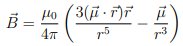
(формула в системе единиц СИ)

## Модель 1 - прямой диполь
В этой модели магнитный диполь (момент) Земли направлен по оси вращения Земли (далее будет обозначаться **m**). Это значит, что вектор магнитного момента остаётся постоянным во времени (прецессию и нутацию оси Земли я не учитываю, модель и так достаточно грубая):
$$
\textbf{m}=m_0\;\textbf{k}\\
\textbf{k}=
\begin{pmatrix}
0\\
0\\
-1
\end{pmatrix}_{ITRS}=
\begin{pmatrix}
0\\
0\\
-1
\end{pmatrix}_{GCRS}\\
$$
В данном приближении я так же считаю, что оси z ITRS и GCRS сонаправлены

In [2]:
m4pi = constants.mmE * constants.m0 / (4 * np.pi)

def B1(r):
    # r - np.ndarray; radius-vector [x, y, z]
    # returns magnetic field vector B in ECI system
    global m04pi
    rr = np.linalg.norm(r)
    k1 = np.array([0., 0., -1.])
    B = -m4pi * (3 * r[2] * r / rr**2 + k1) / rr**3
    return B

In [3]:
# построю картину в плоскость Oxz для проверки результатов
N = 20
m = 3
x2 = np.linspace(constants.RE/m, constants.RE, N)
x1 = np.linspace(-constants.RE, -constants.RE/m, N)
z2 = np.linspace(constants.RE/m, constants.RE, N)
z1 = np.linspace(-constants.RE, -constants.RE/m, N)
x = np.hstack((x1, x2))
z = np.hstack((z1, z2))

b = np.empty((*x.shape, *z.shape, 3))

for i in range(x.shape[0]):
    for j in range(z.shape[0]):
        b[i, j] = B1(np.array([x[i], 0, z[j]]))

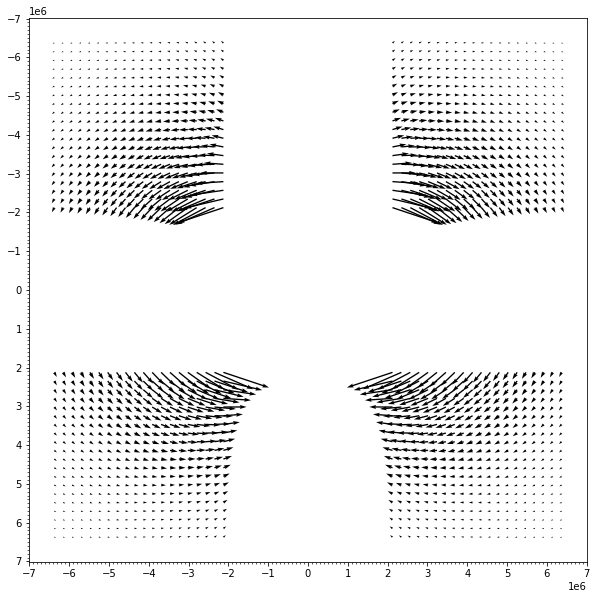

In [4]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1e6))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1e6))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1e5))
# приходится немного колдовать, так как ось y на изображении по умолчанию направлена ВНИЗ
ax.invert_yaxis()
q = ax.quiver(x, z, b[:, :, 0], b[:, :, 2], scale = None)

Красиво. Видно, что поле считается как и должно (обратите внимание, что ось **Оу** направлена вниз)

## Модель 2 - наклонный диполь
В этой модели диполь отклонён от оси вращения земли на ~9.5 градусов.  
Из-за этого приходится учитывать вращение Земли:
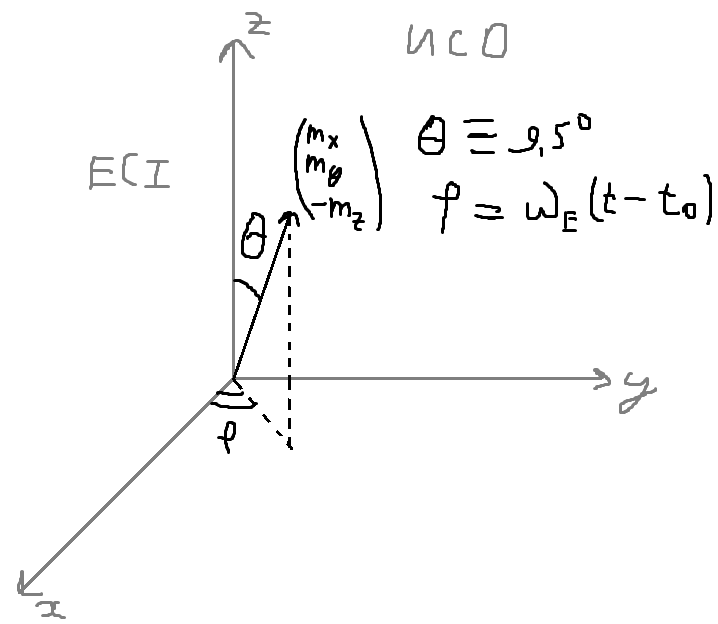

In [5]:
m4pi = constants.mmE * constants.m0 / (4 * np.pi)
T = 24 * 60 * 60
wE = 2 * np.pi / T # Earths angular speed

def ECEF2ECI(a, t, t0 = 0, fi0 = 0):
    # converts a-vector from ECEF (Earth-bounded system) to ECI (Inertial system)
    global T, wE
    dt = (t - t0) % T
    fi = -(fi0 + wE * dt)
    # rotation matrix in terms of coordinates: x_new = M @ x_old
    M = np.array([[np.cos(fi), np.sin(fi), 0],
                  [-np.sin(fi), np.cos(fi), 0],
                  [0, 0, 1]])
    return M @ a
    
def B2(r, t, t0 = 0, theta = 9.5 * np.pi / 180, fi0 = 0):
    # r - np.ndarray; radius-vector [x, y, z]
    # theta - declination of the magnetic moment from z-axis
    # t0 - time moment when ECI and ECEF matched
    # fi0 - fi at t0
    # returns magnetic field vector B in ECI system
    global m04pi
    k1 = np.array([np.sin(theta), 
                   0, 
                   -np.cos(theta)])
    k1 = ECEF2ECI(k1, t, t0 = t0, fi0 = fi0)
    rr = np.linalg.norm(r)
    B = m4pi * (3 * np.dot(k1, r) * r / rr**2 - k1) / rr**3
    return B

In [6]:
# построю картину в плоскость Oxz для проверки результатов
N = 20
m = 3
x2 = np.linspace(constants.RE/m, constants.RE, N)
x1 = np.linspace(-constants.RE, -constants.RE/m, N)
z2 = np.linspace(constants.RE/m, constants.RE, N)
z1 = np.linspace(-constants.RE, -constants.RE/m, N)
x = np.hstack((x1, x2))
z = np.hstack((z1, z2))

b = np.empty((*x.shape, *z.shape, 3))

t = 0

for i in range(x.shape[0]):
    for j in range(z.shape[0]):
        b[i, j] = B2(np.array([x[i], 0, z[j]]), t, theta = 45 / 180 * np.pi)
        # ставлю 45 градусов для валидации

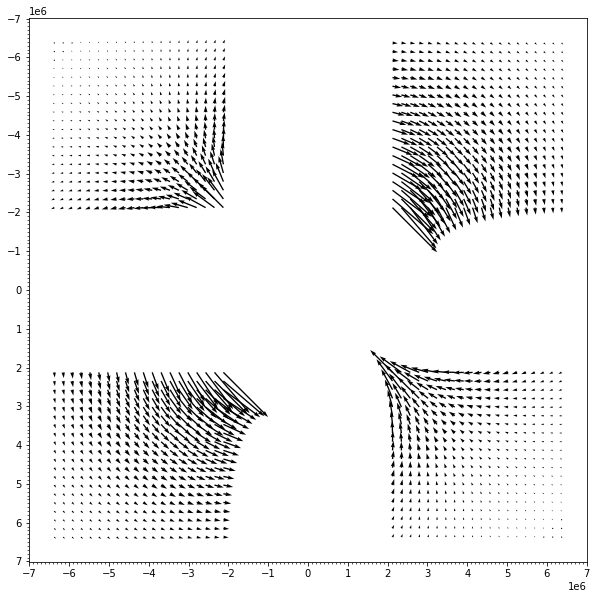

In [7]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1e6))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1e5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1e6))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1e5))
# приходится немного колдовать, так как ось y на изображении по умолчанию направлена ВНИЗ
ax.invert_yaxis()
q = ax.quiver(x, z, b[:, :, 0], b[:, :, 2], scale = None)

И тут всё нормально. При отклонении диполя на 45 градусов линии меняют своё направление как и ожидалось.

## Включение в уравнения движений

In [8]:
def RK4(f, x0x1, y0, step, save_steps :int = 1, step_process = lambda y: y):
    # f MUST takes x and y as arguments: f(x, y)
    # It solves equation y' = f(x, y), y(x0) = y0 (everything is a vector)
    # from x0x1[0] to x0x1[1] on the grid with step step
    # save_steps - INT >= 1; integrator will save results every save_steps steps (2 - every second step, 1 - every step, etc.)
    # save_steps doesn't affect starting point and final point
    # step_process - FUNCTION that is called after every step to somehow process results (normalization and so on)
    # step_process - must take y argument (for single time step) as input and return the same shape numpy.ndarray
    # by default it doesn't do anything
    # returns array of (x, y) pairs
    if not isinstance(save_steps, int):
        raise TypeError("save_steps MUST be an integer")
    elif save_steps <= 0:
        raise ValueError("save_steps MUST be a natural number (1, 2, 3, ...)")
    
    x0 = x0x1[0]
    x1 = x0x1[1]
    current_x = np.array(x0, dtype = np.float64)
    current_y = np.array(y0, dtype = np.float64)
    result = [[x0, *y0]]
    h = step
    h2 = h/2
    h6 = h/6
    stop = x1 - h
    ind = 0
    while current_x < stop:
        ind += 1
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_y = step_process(current_y)
        current_x += h
        if ind == save_steps:
            result.append(np.array([current_x.copy(), *current_y.copy()]))
            ind = 0

    if current_x < x1 - constants.max_to_zero:
        h = x1 - current_x
        h2 = h/2
        h6 = h/6
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_y = step_process(current_y)
        current_x += h
        result.append(np.array([current_x.copy(), *current_y.copy()]))       
    
    return np.array(result)


class parameters:
    pass

J = np.zeros((3, 3))
J[0,0] = 1
J[1, 1] = 3
J[2, 2] = 2
Jinv = np.linalg.inv(J)

params = parameters()
params.J = J
params.Jinv = Jinv
params.mu = constants.muE

In [9]:
m4pi = constants.mmE * constants.m0 / (4 * np.pi)
T = 24 * 60 * 60
wE = 2 * np.pi / T # Earths angular speed

def ECEF2ECI(a, t, t0 = 0, fi0 = 0):
    # converts a-vector from ECEF (Earth-bounded system) to ECI (Inertial system)
    global T, wE
    dt = (t - t0) % T
    fi = -(fi0 + wE * dt)
    # rotation matrix in terms of coordinates: x_new = M @ x_old
    M = np.array([[np.cos(fi), np.sin(fi), 0],
                  [-np.sin(fi), np.cos(fi), 0],
                  [0, 0, 1]])
    return M @ a
    
def B2(r, t, t0 = 0, theta = 9.5 * np.pi / 180, fi0 = 0):
    # r - np.ndarray; radius-vector [x, y, z]
    # theta - declination of the magnetic moment from z-axis
    # t0 - time moment when ECI and ECEF matched
    # fi0 - fi at t0
    # returns magnetic field vector in INERTIAL system
    global m04pi
    k1 = np.array([np.sin(theta), 
                   0, 
                   -np.cos(theta)])
    k1 = ECEF2ECI(k1, t, t0 = t0, fi0 = fi0)
    rr = np.linalg.norm(r)
    B = m4pi * (3 * np.dot(k1, r) * r / rr**2 - k1) / rr**3
    return B

def GravTorque(t, r, V, we, A, Ainv, params):
    # xe = ST * xi = A.inverse * xi * A
    # takes r, V in inertial reference system
    # w, A in bounded system; A as quaternion!
    # Conversion is supposed to be carried out in overlying function
    # returns gravitational torque IN BOUNDED basis
    rr = np.linalg.norm(r)
    e3 = r / rr # in ifr
    e3 = (Ainv * np.quaternion(*e3) * A).vec # convertion to bounded basis
    Me = 3 * params.mu / rr**3 * np.cross(e3, params.J @ e3)
    return Me

def MagneticTorque(t, r, V, we, A, Ainv, m, params, Bfunc = B2):
    # xe = ST * xi = A.inverse * xi * A
    # takes r, V in inertial reference system
    # w, A, Ainv in bounded system; A, Ainv as quaternions!
    # Conversions is supposed to be carried out in overlying function
    # returns magnetic torque IN BOUNDED basis
    B = Bfunc(r, t)
    B = (Ainv * np.quaternion(*B) * A).vec # convertion to bounded basis
    Mm = np.cross(m, B)
    return Mm



def Torque(t, r, V, we, A, params):
    # xe = ST * xi = A.inverse * xi * A
    # takes r, V in inertial reference system
    # w, A in bounded system as arrays
    # returns torque IN BOUNDED basis
    A = np.quaternion(*A)
    Ainv = A.inverse()
    M = np.zeros(3)
    M += GravTorque(t, r, V, we, A, Ainv, params)
    # in future here will be m() - function
    m = [0, 0, 10] # self magnetic moment in bounded system; 10 A, 10 cm^2, 100 rounds
    M += MagneticTorque(t, r, V, we, A, Ainv, m, params)
    return M

def QuatDot(Ai, we):
    return np.quaternion(*Ai) * np.quaternion(*we) * 0.5

def Euler(t, r, V, we, A, params, M = lambda t, r, V, we, A: np.array([0, 0, 0])):
    # return w' accroding to Euler's dinamic equation
    # A - orientation QUATERNION
    # M(t, w, A) - function of external moment in bounded axes
    return params.Jinv @ (M(t, r, V, we, A, params) - np.cross(we, params.J @ we))

def f(t, x, params):
    # x[:3] - r, x[3:6] - V, x[6:9] - we, x[9:] - Ai
    r = x[:3]
    V = x[3:6]
    we = x[6:9]
    A = x[9:]
    
    res = np.empty(13)
    res[:3] = V
    res[3:6] = -params.mu * r / np.linalg.norm(r)**3
    res[6:9] = Euler(t, r, V, we, A, params, Torque)
    res[9:] = QuatDot(A, we).components
    return res

def normalization(x):
    x[9:] /= np.linalg.norm(x[9:])
    return x

In [10]:
t0 = 0
t1 = 92*60
step = 0.1

r0 = np.array([1, 0, 0]) * (constants.RE + constants.ISS_periapsis)
# хочу круговую орбиту
V0 = np.array([0 , 1, 0]) * np.sqrt(params.mu/np.linalg.norm(r0))
we0 = np.array([0.01, 0.01, 0.01])
A0 = np.quaternion(0.5, 0.5, 0.5, 0.5) # ОСК и ССК совпадают

x0 = np.hstack((r0, V0, we0, A0.components))

resultang = RK4(lambda t, x: f(t, x, params), (t0, t1), x0, step, step_process = normalization)

In [11]:
timepoints = resultang[:, 0]
r = resultang[:, 1:4]
V = resultang[:, 4:7]
we = resultang[:, 7:10]
A = resultang[:, 10:]

E3 = np.array([i / np.linalg.norm(i) for i in r])

E1 = np.array([(i - j * np.dot(i, j)) for i, j in zip(V, E3)])
for i in range(E1.shape[0]):
    E1[i] /= np.linalg.norm(E1[i])

E2 = np.array([np.cross(i, j) for i, j in zip(E3, E1)])

S1 = np.array([np.array([E1[i], E2[i], E3[i]]) for i in range(E1.shape[0])]) # матрицы перехода ИСК -> ОСК x' = Sx (НЕ линал)
S2 = np.array([qt.as_rotation_matrix(np.quaternion(*i)).T for i in A]) # матрицы перехода ИСК -> ССК x' = Sx (НЕ линал)
S3 = np.array([j @ i.T for i, j in zip(S1, S2)]) # матрицы перехода ОСК -> ССК x' = Sx (НЕ линал)
A3 = np.array([qt.from_rotation_matrix(i.T).components for i in S3]) # кватернионы поворота ОСК -> CCК

# Сделаю компоненты кватерниона более гладкими (а то у них знак скачет туда-сюда)
# Мой костыльный метод дальше, когда равновесие искать буду
tol = 0.1
for i in range(1, A3.shape[0]):
    if np.linalg.norm(A3[i] - A3[i-1]) > tol:
        # Если сильно меняется норма - то произошёл "скачок"
        A3[i:] *= -1

In [12]:
wors = []
for i in range(E3.shape[0]):
    wors.append(E2[i] * np.dot(V[i], E1[i]) / np.linalg.norm(r[i]))

for i in range(len(wors)):
    wors[i] = S2[i] @ wors[i]

wors = np.array(wors) # вообще в данном случае орбита круговая и wors +- постоянна по модулю
wr = we - wors # в ССК

# Сам интеграл Якоби
J = []
for i in range(wr.shape[0]):
    J.append(0.5 * np.dot(wr[i], params.J @ wr[i]) + 
             np.linalg.norm(wors[i])**2 * 
             (1.5 * np.dot(S2[i] @ E3[i], params.J @ S2[i] @ E3[i]) - 0.5 * np.dot(S2[i] @ E2[i], params.J @ S2[i] @ E2[i])))
J = np.array(J)
print("Максимальное отклонение интеграла Якоби:", np.max(np.abs(J - J[0])))

Максимальное отклонение интеграла Якоби: 0.00019528206317159335


Видно, что интеграл Якоби уже не сохраняется, значит момент-то работает!